data yang gue pegang: cabai merah keriting, cabai rawit merah, daging ayam ras, daging sapi murni

In [1]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.17" -U

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.17) to /tmp/pip-install-k4v2_ifj/tsfm-public_41f636eaa493415a99abc05b639f60d7
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-k4v2_ifj/tsfm-public_41f636eaa493415a99abc05b639f60d7
  Running command git checkout -q a1da2c54b083e1262e0e3330dcf6ef9d757d8b89
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit a1da2c54b083e1262e0e3330dcf6ef9d757d8b89
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
)
from tsfm_public.toolkit.visualization import plot_predictions

import math
import os
import tempfile
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

#TARGET_DATASET = "etth1" #sesuaikan
#dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv" #sesuaikan


# Results dir
OUT_DIR = "ttm_finetuned_models/"

#DATA PREPARATION

In [6]:
from google.colab import drive
# Mount Google Drive
#drive.mount('/content/drive')

# Path ke file di Google Drive (ganti sesuai lokasi file kamu)
file_path = "/content/drive/My Drive/PROJECT/ARKAVIDIA 9.0/PENYISIHAN/DATASET/ORIGINAL DATASET/Harga Bahan Pangan/train/Cabai Merah Keriting.csv"

TARGET_DATASET = "Cabai Merah Keriting"

cabai_merah_keriting = pd.read_csv(file_path)

cabai_merah_keriting['Date'] = pd.to_datetime(cabai_merah_keriting['Date'])

In [5]:
#interpolate untuk menangani missing value
# Langkah 1: Isi awal & akhir dengan spline
cabai_merah_keriting[cabai_merah_keriting.select_dtypes(include="number").columns] = \
    cabai_merah_keriting.select_dtypes(include="number").interpolate(method="spline", order=2, limit_direction="both")

cabai_merah_keriting[cabai_merah_keriting.select_dtypes(include="number").columns] = \
    cabai_merah_keriting.select_dtypes(include="number").interpolate(method="linear")

# Export to CSV
#cabai_merah_keriting.to_csv("Cabai Merah Keriting (Interpolated).csv")

cabai_merah_keriting.info()

/usr/local/lib/python3.11/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1004 non-null   datetime64[ns]
 1   Aceh                       1004 non-null   float64       
 2   Bali                       1004 non-null   float64       
 3   Banten                     1004 non-null   float64       
 4   Bengkulu                   1004 non-null   float64       
 5   DI Yogyakarta              1004 non-null   float64       
 6   DKI Jakarta                1004 non-null   float64       
 7   Gorontalo                  1004 non-null   float64       
 8   Jambi                      1004 non-null   float64       
 9   Jawa Barat                 1004 non-null   float64       
 10  Jawa Tengah                1004 non-null   float64       
 11  Jawa Timur                 1004 non-null   float64       
 12  Kalima

In [ ]:
cabai_merah_keriting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1004 non-null   datetime64[ns]
 1   Aceh                       1004 non-null   float64       
 2   Bali                       1004 non-null   float64       
 3   Banten                     1004 non-null   float64       
 4   Bengkulu                   1004 non-null   float64       
 5   DI Yogyakarta              1004 non-null   float64       
 6   DKI Jakarta                1004 non-null   float64       
 7   Gorontalo                  1004 non-null   float64       
 8   Jambi                      1004 non-null   float64       
 9   Jawa Barat                 1004 non-null   float64       
 10  Jawa Tengah                1004 non-null   float64       
 11  Jawa Timur                 1004 non-null   float64       
 12  Kalima

In [6]:
#attributes
file_path = "/content/drive/My Drive/PROJECT/ARKAVIDIA 9.0/PENYISIHAN/DATASET/Attributes (Imputed by Interpolation).csv"
attributes = pd.read_csv(file_path)
attributes['Date'] = pd.to_datetime(attributes['Date'], dayfirst=True)


In [7]:
#test
file_path = "/content/drive/My Drive/PROJECT/ARKAVIDIA 9.0/PENYISIHAN/DATASET/TEST/merged_dataset_interpolated1.csv"
test = pd.read_csv(file_path)
test['Date'] = pd.to_datetime(test['Date'], dayfirst=True)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     92 non-null     datetime64[ns]
 1   Change % Crude Oil       92 non-null     float64       
 2   Price Crude Oil          92 non-null     float64       
 3   USDIDR Close             92 non-null     float64       
 4   Change % Natural Gas     92 non-null     float64       
 5   Price Natural Gas        92 non-null     float64       
 6   Change % Newcastle Coal  92 non-null     float64       
 7   Price Newcastle Coal     92 non-null     float64       
 8   Change % Palm Oil        92 non-null     float64       
 9   Price Palm Oil           92 non-null     float64       
 10  Change % US Sugar        92 non-null     float64       
 11  Price US Sugar           92 non-null     float64       
 12  Change % US Wheat        92 non-null  

In [8]:
#gabungkan atribut
def merge_dataframes(df_A, df_B):
    # Menyamakan urutan kolom df_B agar sesuai dengan df_A
    df_B = df_B[df_A.columns]

    # Menggabungkan kedua dataframe
    df_C = pd.concat([df_A, df_B], ignore_index=True)

    return df_C

# Contoh penggunaan

attributes = merge_dataframes(attributes, test)

In [ ]:
attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     1096 non-null   datetime64[ns]
 1   USDIDR Close             1096 non-null   float64       
 2   Price Crude Oil          1096 non-null   float64       
 3   Change % Crude Oil       1096 non-null   float64       
 4   Price Natural Gas        1096 non-null   float64       
 5   Change % Natural Gas     1096 non-null   float64       
 6   Price Newcastle Coal     1096 non-null   float64       
 7   Change % Newcastle Coal  1096 non-null   float64       
 8   Price Palm Oil           1096 non-null   float64       
 9   Change % Palm Oil        1096 non-null   float64       
 10  Price US Sugar           1096 non-null   float64       
 11  Change % US Sugar        1096 non-null   float64       
 12  Price US Wheat           1096 non-

In [9]:
#merge attributes and cabai_merah_keriting berdasarkan tanggal
def merge_dataframes(df_A, df_B):
    # Menggabungkan kedua dataframe berdasarkan kolom 'Date'
    df_C = pd.merge(df_A, df_B, on='Date', how='outer')

    return df_C

# Contoh penggunaan
cabai_merah_keriting = merge_dataframes(attributes, cabai_merah_keriting)

In [12]:
cabai_merah_keriting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1096 non-null   datetime64[ns]
 1   USDIDR Close               1096 non-null   float64       
 2   Price Crude Oil            1096 non-null   float64       
 3   Change % Crude Oil         1096 non-null   float64       
 4   Price Natural Gas          1096 non-null   float64       
 5   Change % Natural Gas       1096 non-null   float64       
 6   Price Newcastle Coal       1096 non-null   float64       
 7   Change % Newcastle Coal    1096 non-null   float64       
 8   Price Palm Oil             1096 non-null   float64       
 9   Change % Palm Oil          1096 non-null   float64       
 10  Price US Sugar             1096 non-null   float64       
 11  Change % US Sugar          1096 non-null   float64       
 12  Price 

In [10]:
cabai_merah_keriting = cabai_merah_keriting.fillna(0)

In [12]:
cabai_merah_keriting.tail()

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
1091,2024-12-27,16.230000,70.180000,1.370000,3.514000,-5.410000,126.750000,0.000000,4975.000000,1.530000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1092,2024-12-28,15.898087,70.236338,0.683979,3.607414,-31.483867,125.896713,-0.166993,5002.757913,-0.031579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,2024-12-29,15.898455,70.256133,0.752599,3.617415,-25.761170,125.597535,-0.255668,4973.271736,-0.411671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1094,2024-12-30,16.130000,70.530000,0.500000,3.936000,12.010000,124.550000,-1.740000,4925.000000,-1.010000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1095,2024-12-31,16.090000,71.250000,1.020000,3.633000,-7.700000,125.250000,0.560000,4861.000000,-1.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Kolom yang akan diambil
selected_columns = [
    "Date", "Aceh", "USDIDR Close",
    "Price Crude Oil", "Change % Crude Oil",
    "Price Natural Gas", "Change % Natural Gas",
    "Price Newcastle Coal", "Change % Newcastle Coal",
    "Price Palm Oil", "Change % Palm Oil",
    "Price US Sugar", "Change % US Sugar",
    "Price US Wheat", "Change % US Wheat"
]

#hanya ambil kolom Aceh, USDIDR Close, Price Crude Oil, Change % Crude Oil, Price Natural Gas, Change % Natural Gas, Price Newcastle Coal, Change % Newcastle Coal, Price Palm Oil, Change % Palm Oil, Price US Sugar, Change % US Sugar, Price US Wheat, Change % US Wheat
aceh_as_target = cabai_merah_keriting[selected_columns]

In [ ]:
aceh_as_target.info()

NameError: name 'aceh_as_target' is not defined

In [ ]:
aceh_as_target.head()

,Date,Aceh,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,Price US Sugar,Change % US Sugar,Price US Wheat,Change % US Wheat
0,2022-01-01,22360.0,14209.39169,75.867127,-1.226089,3.995255,-27.948558,-125.386821,-436.985875,6.601437,3.357832,18.446574,0.916577,662.463126,-24.536968
1,2022-01-02,23340.0,14190.20660,76.137177,0.199693,4.031116,-5.028045,57.687037,-156.300483,6.592109,2.630141,18.454580,0.170590,722.150195,-10.285339
2,2022-01-03,22050.0,14215.00000,75.850000,1.300000,3.678000,3.400000,157.500000,-7.130000,5.259000,1.940000,18.740000,-0.740000,758.000000,-1.650000
3,2022-01-04,22460.0,14283.59961,76.740000,1.170000,3.582000,-2.610000,174.100000,10.540000,5.308000,0.930000,18.750000,0.050000,770.000000,1.580000
4,2022-01-05,19630.0,14385.50000,77.470000,0.950000,3.710000,3.570000,179.900000,3.330000,5.437000,2.430000,18.340000,-2.190000,760.750000,-1.200000


In [ ]:
import pymc as pm

#tangani missing value
kolom_dengan_nan = aceh_as_target.columns[aceh_as_target.isna().sum() > 0].tolist()

kolom_numerik_dengan_nan = [col for col in kolom_dengan_nan if aceh_as_target[col].dtype in ['float64', 'int64']]

if not kolom_numerik_dengan_nan:
    raise ValueError("Tidak ada kolom numerik dengan NaN untuk diimputasi.")

imputed_values = {}

# Loop untuk setiap kolom dengan NaN
for kolom in kolom_numerik_dengan_nan:
    print(f"📌 Mengimputasi kolom: {kolom}")

    with pm.Model():
        mu = pm.Normal("mu", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Data yang tersedia (tidak NaN)
        observed = pm.Normal("observed", mu=mu, sigma=sigma,
                             observed=aceh_as_target[kolom][aceh_as_target[kolom].notna()])

        # Variabel untuk data yang hilang (NaN)
        missing_values = pm.Normal("missing_values", mu=mu, sigma=sigma,
                                   shape=int(aceh_as_target[kolom].isna().sum()))  # ✅ FIX: Konversi ke int Python

        # Sampling
        trace = pm.sample(1000, return_inferencedata=True)

    # Mengambil  edian dari distribusi posterior sebagai imputasi
    imputed_values[kolom] = trace.posterior["missing_values"]. median(dim=("chain", "draw")).values

    # Mengisi nilai NaN dalam DataFrame dengan hasil imputasi
    aceh_as_target.loc[aceh_as_target[kolom].isna(), kolom] = imputed_values[kolom]

print("✅ Semua nilai NaN telah diimputasi menggunakan PyMC!")

📌 Mengimputasi kolom: Aceh


In [ ]:
aceh_as_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     1004 non-null   datetime64[ns]
 1   Aceh                     1004 non-null   float64       
 2   USDIDR Close             1004 non-null   float64       
 3   Price Crude Oil          1004 non-null   float64       
 4   Change % Crude Oil       1004 non-null   float64       
 5   Price Natural Gas        1004 non-null   float64       
 6   Change % Natural Gas     1004 non-null   float64       
 7   Price Newcastle Coal     1004 non-null   float64       
 8   Change % Newcastle Coal  1004 non-null   float64       
 9   Price Palm Oil           1004 non-null   float64       
 10  Change % Palm Oil        1004 non-null   float64       
 11  Price US Sugar           1004 non-null   float64       
 12  Change % US Sugar        1004 non-

In [ ]:
# Path ke file di Google Drive (ganti sesuai lokasi file kamu)
test_dataset_path = "/content/drive/My Drive/PROJECT/ARKAVIDIA 9.0/PENYISIHAN/DATASET/TEST/merged_dataset_interpolated1.csv"

TARGET_DATASET = "Merged Dataset Interpolated1"

dset_test = pd.read_csv(test_dataset_path)

dset_test['Date'] = pd.to_datetime(dset_test['Date'], dayfirst=True)

In [ ]:
dset_test.head()

,Date,Change % Crude Oil,Price Crude Oil,USDIDR Close,Change % Natural Gas,Price Natural Gas,Change % Newcastle Coal,Price Newcastle Coal,Change % Palm Oil,Price Palm Oil,US Sugar Change %,Price US Sugar,Change % US Wheat,Price US Wheat
0,2024-10-01,2.390000,69.390000,15.195000,-1.700000,3.288000,-2.380000,141.65000,1.020000,4166.000000,1.320000,22.970000,2.570000,599.000000
1,2024-10-02,0.430000,69.690000,15.260000,0.270000,3.297000,-0.990000,140.25000,3.340000,4305.000000,-1.260000,22.680000,2.710000,615.250000
2,2024-10-03,4.990000,73.170000,15.415000,2.180000,3.369000,0.390000,140.80000,-0.880000,4267.000000,2.470000,23.240000,-1.910000,603.500000
3,2024-10-04,0.700000,73.680000,15.480000,-1.900000,3.305000,5.260000,148.20000,3.120000,4400.000000,-0.990000,23.010000,-2.280000,589.750000
4,2024-10-05,1.999549,74.410291,15.860271,-16.989323,2.885286,3.475454,150.68326,1.053665,4471.735921,-0.952866,21.376932,-1.988848,584.760602


In [ ]:
#cabai_merah_keriting = cabai_merah_keriting.merge(attributes, on='Date', how='left')

#MODELLING

In [79]:
timestamp_column = "Date"
id_columns = []
target_columns = ["Aceh", "Bali", "Banten", "Bengkulu", "DI Yogyakarta", "DKI Jakarta", "Gorontalo", "Jambi", "Jawa Barat", "Jawa Tengah", "Jawa Timur", "Kalimantan Barat", "Kalimantan Selatan", "Kalimantan Tengah", "Kalimantan Timur", "Kalimantan Utara", "Kepulauan Bangka Belitung", "Kepulauan Riau", "Lampung", "Maluku Utara", "Maluku", "Nusa Tenggara Barat", "Nusa Tenggara Timur", "Papua Barat", "Papua", "Riau", "Sulawesi Barat", "Sulawesi Selatan", "Sulawesi Tengah", "Sulawesi Tenggara", "Sulawesi Utara", "Sumatera Barat", "Sumatera Selatan", "Sumatera Utara"]
context_length = 512

In [80]:
cabai_merah_keriting

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
0,2022-01-01,14209.391690,75.867127,-1.226089,3.995255,-27.948558,-125.386821,-436.985875,6.601437,3.357832,...,86390.0,35800.0,50960.0,41660.0,46480.0,60540.0,48880.0,26990.0,42410.0,26180.0
1,2022-01-02,14190.206600,76.137177,0.199693,4.031116,-5.028045,57.687037,-156.300483,6.592109,2.630141,...,75750.0,34760.0,49550.0,40360.0,45520.0,58830.0,48800.0,26470.0,44750.0,27290.0
2,2022-01-03,14215.000000,75.850000,1.300000,3.678000,3.400000,157.500000,-7.130000,5.259000,1.940000,...,68260.0,35170.0,45980.0,41100.0,46990.0,56570.0,49150.0,27780.0,41320.0,24460.0
3,2022-01-04,14283.599610,76.740000,1.170000,3.582000,-2.610000,174.100000,10.540000,5.308000,0.930000,...,69250.0,35220.0,45630.0,39990.0,46490.0,56630.0,45860.0,29880.0,38530.0,23790.0
4,2022-01-05,14385.500000,77.470000,0.950000,3.710000,3.570000,179.900000,3.330000,5.437000,2.430000,...,66910.0,34140.0,40190.0,39460.0,45330.0,56100.0,44600.0,28320.0,40680.0,24520.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,16.230000,70.180000,1.370000,3.514000,-5.410000,126.750000,0.000000,4975.000000,1.530000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1092,2024-12-28,15.898087,70.236338,0.683979,3.607414,-31.483867,125.896713,-0.166993,5002.757913,-0.031579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,2024-12-29,15.898455,70.256133,0.752599,3.617415,-25.761170,125.597535,-0.255668,4973.271736,-0.411671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1094,2024-12-30,16.130000,70.530000,0.500000,3.936000,12.010000,124.550000,-1.740000,4925.000000,-1.010000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
data = cabai_merah_keriting.copy()

In [28]:
data

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
0,2022-01-01,14209.391690,75.867127,-1.226089,3.995255,-27.948558,-125.386821,-436.985875,6.601437,3.357832,...,86390.0,35800.0,50960.0,41660.0,46480.0,60540.0,48880.0,26990.0,42410.0,26180.0
1,2022-01-02,14190.206600,76.137177,0.199693,4.031116,-5.028045,57.687037,-156.300483,6.592109,2.630141,...,75750.0,34760.0,49550.0,40360.0,45520.0,58830.0,48800.0,26470.0,44750.0,27290.0
2,2022-01-03,14215.000000,75.850000,1.300000,3.678000,3.400000,157.500000,-7.130000,5.259000,1.940000,...,68260.0,35170.0,45980.0,41100.0,46990.0,56570.0,49150.0,27780.0,41320.0,24460.0
3,2022-01-04,14283.599610,76.740000,1.170000,3.582000,-2.610000,174.100000,10.540000,5.308000,0.930000,...,69250.0,35220.0,45630.0,39990.0,46490.0,56630.0,45860.0,29880.0,38530.0,23790.0
4,2022-01-05,14385.500000,77.470000,0.950000,3.710000,3.570000,179.900000,3.330000,5.437000,2.430000,...,66910.0,34140.0,40190.0,39460.0,45330.0,56100.0,44600.0,28320.0,40680.0,24520.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,16.230000,70.180000,1.370000,3.514000,-5.410000,126.750000,0.000000,4975.000000,1.530000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1092,2024-12-28,15.898087,70.236338,0.683979,3.607414,-31.483867,125.896713,-0.166993,5002.757913,-0.031579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,2024-12-29,15.898455,70.256133,0.752599,3.617415,-25.761170,125.597535,-0.255668,4973.271736,-0.411671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1094,2024-12-30,16.130000,70.530000,0.500000,3.936000,12.010000,124.550000,-1.740000,4925.000000,-1.010000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
cabai_merah_keriting

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
0,2022-01-01,14209.391690,75.867127,-1.226089,3.995255,-27.948558,-125.386821,-436.985875,6.601437,3.357832,...,86390.0,35800.0,50960.0,41660.0,46480.0,60540.0,48880.0,26990.0,42410.0,26180.0
1,2022-01-02,14190.206600,76.137177,0.199693,4.031116,-5.028045,57.687037,-156.300483,6.592109,2.630141,...,75750.0,34760.0,49550.0,40360.0,45520.0,58830.0,48800.0,26470.0,44750.0,27290.0
2,2022-01-03,14215.000000,75.850000,1.300000,3.678000,3.400000,157.500000,-7.130000,5.259000,1.940000,...,68260.0,35170.0,45980.0,41100.0,46990.0,56570.0,49150.0,27780.0,41320.0,24460.0
3,2022-01-04,14283.599610,76.740000,1.170000,3.582000,-2.610000,174.100000,10.540000,5.308000,0.930000,...,69250.0,35220.0,45630.0,39990.0,46490.0,56630.0,45860.0,29880.0,38530.0,23790.0
4,2022-01-05,14385.500000,77.470000,0.950000,3.710000,3.570000,179.900000,3.330000,5.437000,2.430000,...,66910.0,34140.0,40190.0,39460.0,45330.0,56100.0,44600.0,28320.0,40680.0,24520.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,16.230000,70.180000,1.370000,3.514000,-5.410000,126.750000,0.000000,4975.000000,1.530000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1092,2024-12-28,15.898087,70.236338,0.683979,3.607414,-31.483867,125.896713,-0.166993,5002.757913,-0.031579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,2024-12-29,15.898455,70.256133,0.752599,3.617415,-25.761170,125.597535,-0.255668,4973.271736,-0.411671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1094,2024-12-30,16.130000,70.530000,0.500000,3.936000,12.010000,124.550000,-1.740000,4925.000000,-1.010000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_start = 0
train_end = int(0.7 * len(cabai_merah_keriting))
valid_start = int(0.7 * len(cabai_merah_keriting))
valid_end = int(0.85 * len(cabai_merah_keriting))
test_start = int(0.85 * len(cabai_merah_keriting))
test_end = len(cabai_merah_keriting)
# Split configuration (70% train, 15% valid, 15% test)
split_config = {
    "train": [train_start, train_end],
    "valid": [valid_start, valid_end],
    "test": [test_start, test_end]
    #"train": [0, int(0.7 * len(cabai_merah_keriting))],
    #"valid": [int(0.7 * len(cabai_merah_keriting)), int(0.85 * len(cabai_merah_keriting))],
    #"test": [int(0.85 * len(cabai_merah_keriting)), len(cabai_merah_keriting)]

}

In [82]:
# Pastikan kolom 'Date' dalam format datetime
cabai_merah_keriting["Date"] = pd.to_datetime(cabai_merah_keriting["Date"])

# Tentukan batas waktu untuk setiap split
train_start = "2022-01-01"
train_end = "2024-09-30"
test_start = "2024-10-01"
test_end = "2024-12-31"

# Filter dataset berdasarkan rentang waktu
train_data = cabai_merah_keriting[(cabai_merah_keriting["Date"] >= train_start) & (cabai_merah_keriting["Date"] <= train_end)]

test_data = cabai_merah_keriting[(cabai_merah_keriting["Date"] >= test_start) & (cabai_merah_keriting["Date"] <= test_end)]

# Split validation dari bagian belakang train_data (misal 15% dari train)
#valid_size = int(0.15 * len(train_data))
#valid_data = train_data.iloc[-valid_size:]  # Ambil bagian terakhir sebagai validasi
#train_data = train_data.iloc[:-valid_size]  # Sisakan sisanya sebagai train

# Ambil index numerik untuk split_config
train_start_idx = 0
train_end_idx = len(train_data)
valid_start_idx = int(0.85 * len(train_data))
valid_end_idx = train_end_idx
test_start_idx = train_end_idx
test_end_idx = train_end_idx + len(test_data)

# Split configuration berdasarkan tanggal
split_config = {
    #"train": [train_data["Date"].iloc[0], train_data["Date"].iloc[-1]],
    #"valid": [valid_data["Date"].iloc[0], valid_data["Date"].iloc[-1]],
    #"test": [test_data["Date"].iloc[0], test_data["Date"].iloc[-1]]

    "train": [train_start_idx, valid_start_idx],
    "valid": [valid_start_idx, valid_end_idx],
    "test": [test_start_idx, test_end_idx]
}

# Cek hasilnya
print(split_config)

{'train': [0, 853], 'valid': [853, 1004], 'test': [1004, 1096]}


In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 854 entries, 0 to 853
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       854 non-null    datetime64[ns]
 1   USDIDR Close               854 non-null    float64       
 2   Price Crude Oil            854 non-null    float64       
 3   Change % Crude Oil         854 non-null    float64       
 4   Price Natural Gas          854 non-null    float64       
 5   Change % Natural Gas       854 non-null    float64       
 6   Price Newcastle Coal       854 non-null    float64       
 7   Change % Newcastle Coal    854 non-null    float64       
 8   Price Palm Oil             854 non-null    float64       
 9   Change % Palm Oil          854 non-null    float64       
 10  Price US Sugar             854 non-null    float64       
 11  Change % US Sugar          854 non-null    float64       
 12  Price US Whea

In [34]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 854 to 1003
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       150 non-null    datetime64[ns]
 1   USDIDR Close               150 non-null    float64       
 2   Price Crude Oil            150 non-null    float64       
 3   Change % Crude Oil         150 non-null    float64       
 4   Price Natural Gas          150 non-null    float64       
 5   Change % Natural Gas       150 non-null    float64       
 6   Price Newcastle Coal       150 non-null    float64       
 7   Change % Newcastle Coal    150 non-null    float64       
 8   Price Palm Oil             150 non-null    float64       
 9   Change % Palm Oil          150 non-null    float64       
 10  Price US Sugar             150 non-null    float64       
 11  Change % US Sugar          150 non-null    float64       
 12  Price US W

In [35]:
valid_data.tail()

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
999,2024-09-26,15201.50000,67.190000,-2.810000,2.753000,-2.270000,139.600000,-0.110000,4.235000,2.670000,...,62200.0,37980.0,29790.0,26580.0,42260.0,36400.0,35400.0,29640.0,27810.0,24460.0
1000,2024-09-27,15070.00000,67.670000,0.710000,3.304000,20.010000,139.750000,0.110000,4.159000,-1.790000,...,57260.0,37680.0,29600.0,26170.0,41610.0,41190.0,36290.0,29700.0,27270.0,24260.0
1001,2024-09-28,14987.74271,67.929305,2.946238,3.020455,60.556350,141.680310,1.424441,4.485364,-8.590171,...,59930.0,37740.0,29730.0,25030.0,40750.0,39010.0,36410.0,29460.0,27280.0,23050.0
1002,2024-09-29,15003.43878,67.258501,2.682578,3.028784,54.313534,143.105988,2.425334,4.490478,-8.277359,...,60020.0,36830.0,30470.0,25570.0,40780.0,39490.0,36160.0,29200.0,27930.0,22450.0
1003,2024-09-30,15118.00000,67.770000,0.150000,3.345000,1.240000,145.100000,3.830000,4.124000,-0.840000,...,60640.0,36930.0,29920.0,25550.0,39650.0,42140.0,36310.0,28520.0,27560.0,22980.0


In [38]:
test_data.tail()

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
1091,2024-12-27,16.230000,70.180000,1.370000,3.514000,-5.410000,126.750000,0.000000,4975.000000,1.530000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1092,2024-12-28,15.898087,70.236338,0.683979,3.607414,-31.483867,125.896713,-0.166993,5002.757913,-0.031579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,2024-12-29,15.898455,70.256133,0.752599,3.617415,-25.761170,125.597535,-0.255668,4973.271736,-0.411671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1094,2024-12-30,16.130000,70.530000,0.500000,3.936000,12.010000,124.550000,-1.740000,4925.000000,-1.010000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1095,2024-12-31,16.090000,71.250000,1.020000,3.633000,-7.700000,125.250000,0.560000,4861.000000,-1.300000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

In [ ]:
test_end

1096

##Cookbook

In [ ]:
# Only use the last `context_length` rows for prediction.
input_df = aceh_as_target.iloc[-CONTEXT_LENGTH:,]

# Show the last few rows of the dataset.
input_df.tail()

,Date,Aceh,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,Price US Sugar,Change % US Sugar,Price US Wheat,Change % US Wheat
999,2024-09-26,26990.0,15201.50000,67.190000,-2.810000,2.753000,-2.270000,139.600000,-0.110000,4.235000,2.670000,23.310000,-0.470000,584.250000,-0.850000
1000,2024-09-27,26210.0,15070.00000,67.670000,0.710000,3.304000,20.010000,139.750000,0.110000,4.159000,-1.790000,22.790000,-2.230000,580.000000,-0.730000
1001,2024-09-28,25950.0,14987.74271,67.929305,2.946238,3.020455,60.556350,141.680310,1.424441,4.485364,-8.590171,21.469367,-2.457755,578.176717,-1.640788
1002,2024-09-29,26140.0,15003.43878,67.258501,2.682578,3.028784,54.313534,143.105988,2.425334,4.490478,-8.277359,21.547954,-1.978998,579.541224,-1.000224
1003,2024-09-30,25510.0,15118.00000,67.770000,0.150000,3.345000,1.240000,145.100000,3.830000,4.124000,-0.840000,22.670000,-0.530000,584.000000,0.690000


In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 284 to 1003
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     720 non-null    datetime64[ns]
 1   Aceh                     720 non-null    float64       
 2   USDIDR Close             720 non-null    float64       
 3   Price Crude Oil          720 non-null    float64       
 4   Change % Crude Oil       720 non-null    float64       
 5   Price Natural Gas        720 non-null    float64       
 6   Change % Natural Gas     720 non-null    float64       
 7   Price Newcastle Coal     720 non-null    float64       
 8   Change % Newcastle Coal  720 non-null    float64       
 9   Price Palm Oil           720 non-null    float64       
 10  Change % Palm Oil        720 non-null    float64       
 11  Price US Sugar           720 non-null    float64       
 12  Change % US Sugar        720 non-

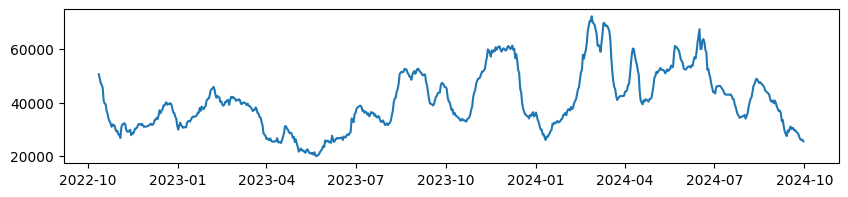

In [ ]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df[timestamp_column], input_df[target_column])

In [ ]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on Hugging Face
    num_input_channels=len(target_columns),  # tsp.num_input_channels
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [ ]:
# Create a pipeline.
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=False,
    freq="h",
    device="cuda",  # Specify your local GPU or CPU.
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.tail()

Device set to use cuda


,Date,Aceh_prediction,Aceh
204,2024-09-26,"[25228.759765625, 25503.68359375, 25692.351562...","[26210.0, 25950.0, 26140.0, 25510.0, nan, nan,..."
205,2024-09-27,"[24444.619140625, 24778.56640625, 24856.855468...","[25950.0, 26140.0, 25510.0, nan, nan, nan, nan..."
206,2024-09-28,"[24272.951171875, 24544.326171875, 24402.77343...","[26140.0, 25510.0, nan, nan, nan, nan, nan, na..."
207,2024-09-29,"[24492.267578125, 24559.859375, 24545.20898437...","[25510.0, nan, nan, nan, nan, nan, nan, nan, n..."
208,2024-09-30,"[23831.271484375, 24008.544921875, 24133.86328...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


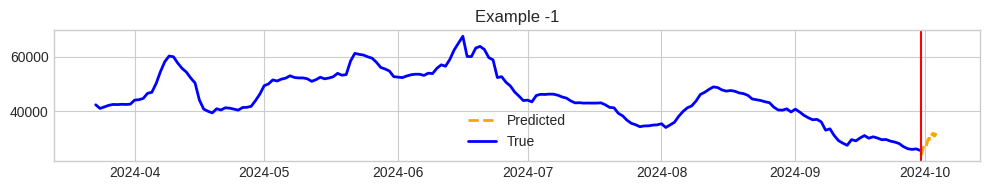

In [ ]:
# Plot the historical data and predicted series.
plot_predictions(
    input_df=input_df,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[-1],
    num_plots=1,
)

In [ ]:
predictions_df

NameError: name 'predictions_df' is not defined

In [ ]:
zeroshot_forecast

#export
zeroshot_forecast.to_csv("zeroshot_forecast.csv")

##Zeroshot Evaluation

In [84]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config)

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=None,
        #freq=None,
        #prefer_l1_loss=False,
        #prefer_longer_context=True,
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    print(f"Jumlah sampel dalam dset_test: {len(dset_test)}")

    # plot
    #plot_predictions(
    #    model=zeroshot_trainer.model,
    #    dset=dset_test,
    #    plot_dir=os.path.join(OUT_DIR, dataset_name),
    #    plot_prefix="test_zeroshot",
    #    indices=[1],
    #    #indices = [i for i in [685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015] if test_start <= i < test_end],
    #    channel=0,
    #)

    # Ambil indeks dari dataset test
    #test_indices = list(range(len(dset_test)))

    #return dset_test, test_indices

    dset_test = pd.DataFrame([sample for sample in dset_test])
    dset_test.to_csv("dset_test.csv", index=False)

##Zeroshot

In [85]:
TARGET_DATASET = "Cabai Merah Keriting"

In [86]:
print(f"Dataset shape: {TARGET_DATASET.shape if hasattr(TARGET_DATASET, 'shape') else len(TARGET_DATASET)}")
print(f"Context length: {CONTEXT_LENGTH}, Forecast length: {PREDICTION_LENGTH}")


Dataset shape: 20
Context length: 512, Forecast length: 96


In [61]:
print(len(TARGET_DATASET))  # Pastikan dataset memiliki data

20


In [87]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.06372116506099701, 'eval_model_preparation_time': 0.0045, 'eval_runtime': 0.0878, 'eval_samples_per_second': 11.387, 'eval_steps_per_second': 11.387}
(1, 96, 34)
(1, 34, 8, 192)
Jumlah sampel dalam dset_test: 1


In [67]:
print(f"Jumlah total data sebelum split: {len(dset)}")
print(f"Jumlah data dalam dset_train: {len(dset_train)}")
print(f"Jumlah data dalam dset_test: {len(dset_test)}")


NameError: name 'dset' is not defined

In [ ]:
import torch

# Simpan model
model_path = "zeroshot_model.pt"
torch.save(zeroshot_model.state_dict(), model_path)

print(f"Model disimpan sebagai {model_path}")


NameError: name 'zeroshot_model' is not defined

In [ ]:
import pickle

# Simpan model sebagai pickle
model_path = "zeroshot_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(zeroshot_model, f)

print(f"Model disimpan sebagai {model_path}")


NameError: name 'zeroshot_model' is not defined

###Zeroshot eceran

In [ ]:
data = cabai_merah_keriting.copy()

In [103]:
PREDICTION_LENGTH = 92  # Ubah dari 96 ke 92

In [105]:
forecast_length = PREDICTION_LENGTH

In [108]:
# Pastikan kolom 'Date' dalam format datetime
cabai_merah_keriting["Date"] = pd.to_datetime(cabai_merah_keriting["Date"])

# Tentukan batas waktu untuk setiap split
train_start = "2022-01-01"
train_end = "2024-09-30"
test_start = "2024-10-01"
test_end = "2024-12-31"

# Filter dataset berdasarkan rentang waktu
train_data = cabai_merah_keriting[(cabai_merah_keriting["Date"] >= train_start) & (cabai_merah_keriting["Date"] <= train_end)]

test_data = cabai_merah_keriting[(cabai_merah_keriting["Date"] >= test_start) & (cabai_merah_keriting["Date"] <= test_end)]

# Split validation dari bagian belakang train_data (misal 15% dari train)
#valid_size = int(0.15 * len(train_data))
#valid_data = train_data.iloc[-valid_size:]  # Ambil bagian terakhir sebagai validasi
#train_data = train_data.iloc[:-valid_size]  # Sisakan sisanya sebagai train

# Ambil index numerik untuk split_config
train_start_idx = 0
train_end_idx = len(train_data)
valid_start_idx = int(0.85 * len(train_data))
valid_end_idx = train_end_idx
#test_start_idx = train_end_idx
#test_end_idx = train_end_idx + len(test_data)
test_start_idx = len(data) - PREDICTION_LENGTH
test_end_idx = len(data)  # Ambil sampai akhir dataset

# Split configuration berdasarkan tanggal
split_config = {
    #"train": [train_data["Date"].iloc[0], train_data["Date"].iloc[-1]],
    #"valid": [valid_data["Date"].iloc[0], valid_data["Date"].iloc[-1]],
    #"test": [test_data["Date"].iloc[0], test_data["Date"].iloc[-1]]

    #"train": [train_start_idx, valid_start_idx],
    #"valid": [valid_start_idx, valid_end_idx],
    #"test": [test_start_idx, test_end_idx]

    "train": [0, test_start_idx],
    "valid": [test_start_idx - int(0.15 * test_start_idx), test_start_idx],
    "test": [test_start_idx, test_end_idx]
}

# Cek hasilnya
print(split_config)

{'train': [0, 1004], 'valid': [854, 1004], 'test': [1004, 1096]}


In [89]:
dataset_name=TARGET_DATASET
context_length=CONTEXT_LENGTH
forecast_length=PREDICTION_LENGTH
batch_size=64

In [109]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

In [110]:
# Load model
zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    freq_prefix_tuning=None,
    #freq=None,
    #prefer_l1_loss=False,
    #prefer_longer_context=True,
)

                    Hence, TTM will forecast using the `prediction_filter_length` argument to provide the requested prediction length.
                    Supported context lengths (CL) and forecast/prediction lengths (FL) for Model Card: ibm-granite/granite-timeseries-ttm-r2 are
                    {'CL': [512, 1024, 1536], 'FL': [96, 192, 336, 720]}


In [111]:
dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config)

In [112]:
print(len(dset_test))  # Seharusnya 92
print(dset_test[0])  # Periksa sample pertama test set

1
{'past_values': tensor([[-1.1897, -0.4021, -0.7626,  ..., -1.3061, -1.1346, -1.3764],
        [-1.1851, -0.5280, -0.6850,  ..., -1.2444, -1.1600, -1.3809],
        [-1.2174, -0.3708, -0.6956,  ..., -1.2780, -1.1320, -1.3395],
        ...,
        [-0.9856, -1.0138, -0.8930,  ..., -1.0508, -1.1564, -1.1128],
        [-0.9759, -1.0067, -0.9087,  ..., -1.0654, -1.1226, -1.1469],
        [-1.0082, -0.9749, -0.9279,  ..., -1.1036, -1.1418, -1.1168]]), 'future_values': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'past_observed_mask': tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ...,

In [96]:
temp_dir = tempfile.mkdtemp()

In [97]:
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=batch_size,
        seed=SEED,
        report_to="none",
    ),
)

In [98]:
# evaluate = zero-shot performance
print("+" * 20, "Test MSE zero-shot", "+" * 20)
zeroshot_output = zeroshot_trainer.evaluate(dset_test)
print(zeroshot_output)

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.06372116506099701, 'eval_model_preparation_time': 0.0037, 'eval_runtime': 0.0366, 'eval_samples_per_second': 27.351, 'eval_steps_per_second': 27.351}


In [99]:
# get predictions

predictions_dict = zeroshot_trainer.predict(dset_test)

predictions_np = predictions_dict.predictions[0]

print(predictions_np.shape)

(1, 96, 34)


In [ ]:
# get backbone embeddings (if needed for further analysis)

backbone_embedding = predictions_dict.predictions[1]

print(backbone_embedding.shape)

(70, 34, 8, 192)


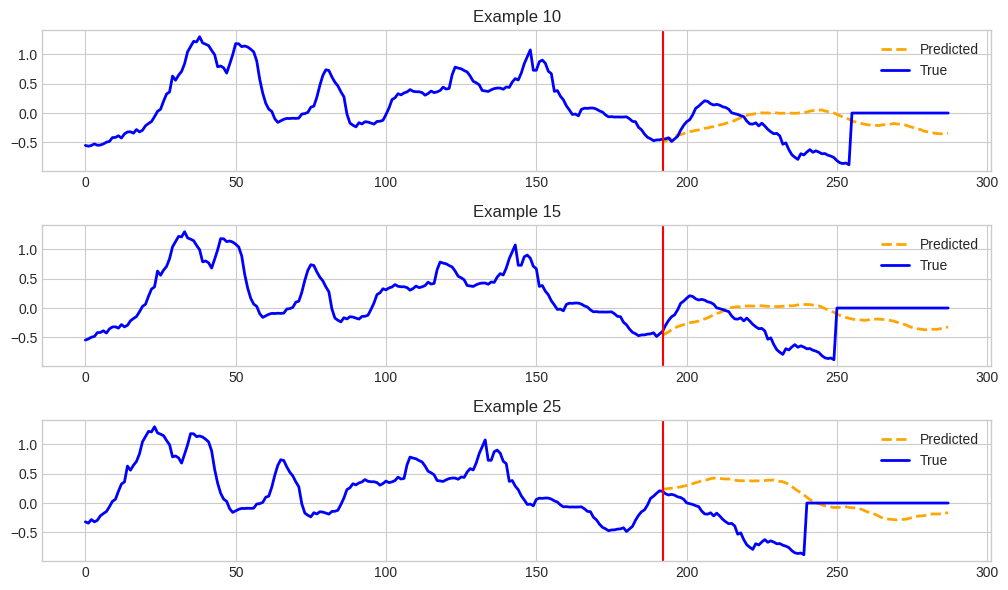

In [ ]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=dset_test,
    plot_dir=os.path.join(OUT_DIR, dataset_name),
    plot_prefix="test_zeroshot",
    indices=[10, 15, 25],
    #indices = [i for i in [685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015] if test_start <= i < test_end],
    channel=0,
)

In [ ]:
#return dset_test, test_indices
dset_test = pd.DataFrame([sample for sample in dset_test])
dset_test.to_csv("dset_test.csv", index=False)

In [ ]:
import torch

# Simpan model
model_path = "zeroshot_model.pt"
torch.save(zeroshot_model.state_dict(), model_path)

print(f"Model disimpan sebagai {model_path}")


Model disimpan sebagai zeroshot_model.pt


In [ ]:
import pickle

# Simpan model sebagai pickle
model_path = "zeroshot_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(zeroshot_model, f)

print(f"Model disimpan sebagai {model_path}")


Model disimpan sebagai zeroshot_model.pkl


#APPLY TO TEST SET

In [ ]:
# Path ke file di Google Drive (ganti sesuai lokasi file kamu)
test_dataset_path = "/content/drive/My Drive/PROJECT/ARKAVIDIA 9.0/PENYISIHAN/DATASET/TEST/merged_dataset_interpolated1.csv"

TARGET_DATASET = "Merged Dataset Interpolated1"

test_df = pd.read_csv(test_dataset_path)

test_df['Date'] = pd.to_datetime(test_df['Date'], dayfirst=True)

In [ ]:
# Path ke file di Google Drive (ganti sesuai lokasi file kamu)
test_dataset_path = "/content/drive/My Drive/PROJECT/ARKAVIDIA 9.0/PENYISIHAN/DATASET/TEST/merged_dataset_interpolated1.csv"

TARGET_DATASET = "Merged Dataset Interpolated1"

dset_test = pd.read_csv(test_dataset_path)

dset_test['Date'] = pd.to_datetime(dset_test['Date'], dayfirst=True)

In [ ]:
test_df.head()

,Date,Change % Crude Oil,Price Crude Oil,USDIDR Close,Change % Natural Gas,Price Natural Gas,Change % Newcastle Coal,Price Newcastle Coal,Change % Palm Oil,Price Palm Oil,US Sugar Change %,Price US Sugar,Change % US Wheat,Price US Wheat
0,2024-10-01,2.390000,69.390000,15.195000,-1.700000,3.288000,-2.380000,141.65000,1.020000,4166.000000,1.320000,22.970000,2.570000,599.000000
1,2024-10-02,0.430000,69.690000,15.260000,0.270000,3.297000,-0.990000,140.25000,3.340000,4305.000000,-1.260000,22.680000,2.710000,615.250000
2,2024-10-03,4.990000,73.170000,15.415000,2.180000,3.369000,0.390000,140.80000,-0.880000,4267.000000,2.470000,23.240000,-1.910000,603.500000
3,2024-10-04,0.700000,73.680000,15.480000,-1.900000,3.305000,5.260000,148.20000,3.120000,4400.000000,-0.990000,23.010000,-2.280000,589.750000
4,2024-10-05,1.999549,74.410291,15.860271,-16.989323,2.885286,3.475454,150.68326,1.053665,4471.735921,-0.952866,21.376932,-1.988848,584.760602


In [ ]:
dset_test.head()

,Date,Change % Crude Oil,Price Crude Oil,USDIDR Close,Change % Natural Gas,Price Natural Gas,Change % Newcastle Coal,Price Newcastle Coal,Change % Palm Oil,Price Palm Oil,US Sugar Change %,Price US Sugar,Change % US Wheat,Price US Wheat
0,2024-10-01,2.390000,69.390000,15.195000,-1.700000,3.288000,-2.380000,141.65000,1.020000,4166.000000,1.320000,22.970000,2.570000,599.000000
1,2024-10-02,0.430000,69.690000,15.260000,0.270000,3.297000,-0.990000,140.25000,3.340000,4305.000000,-1.260000,22.680000,2.710000,615.250000
2,2024-10-03,4.990000,73.170000,15.415000,2.180000,3.369000,0.390000,140.80000,-0.880000,4267.000000,2.470000,23.240000,-1.910000,603.500000
3,2024-10-04,0.700000,73.680000,15.480000,-1.900000,3.305000,5.260000,148.20000,3.120000,4400.000000,-0.990000,23.010000,-2.280000,589.750000
4,2024-10-05,1.999549,74.410291,15.860271,-16.989323,2.885286,3.475454,150.68326,1.053665,4471.735921,-0.952866,21.376932,-1.988848,584.760602


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_columns = test_df.select_dtypes(include=['number']).columns
test_df[numerical_columns] = scaler.fit_transform(test_df[numerical_columns])


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_columns = dset_test.select_dtypes(include=['number']).columns
dset_test[numerical_columns] = scaler.fit_transform(dset_test[numerical_columns])


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     92 non-null     datetime64[ns]
 1   Change % Crude Oil       92 non-null     float64       
 2   Price Crude Oil          92 non-null     float64       
 3   USDIDR Close             92 non-null     float64       
 4   Change % Natural Gas     92 non-null     float64       
 5   Price Natural Gas        92 non-null     float64       
 6   Change % Newcastle Coal  92 non-null     float64       
 7   Price Newcastle Coal     92 non-null     float64       
 8   Change % Palm Oil        92 non-null     float64       
 9   Price Palm Oil           92 non-null     float64       
 10  US Sugar Change %        92 non-null     float64       
 11  Price US Sugar           92 non-null     float64       
 12  Change % US Wheat        92 non-null  

In [ ]:
dset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     92 non-null     datetime64[ns]
 1   Change % Crude Oil       92 non-null     float64       
 2   Price Crude Oil          92 non-null     float64       
 3   USDIDR Close             92 non-null     float64       
 4   Change % Natural Gas     92 non-null     float64       
 5   Price Natural Gas        92 non-null     float64       
 6   Change % Newcastle Coal  92 non-null     float64       
 7   Price Newcastle Coal     92 non-null     float64       
 8   Change % Palm Oil        92 non-null     float64       
 9   Price Palm Oil           92 non-null     float64       
 10  US Sugar Change %        92 non-null     float64       
 11  Price US Sugar           92 non-null     float64       
 12  Change % US Wheat        92 non-null  

In [ ]:
import torch
from tsfm_public.toolkit.get_model import get_model

# Load ulang model dengan arsitektur yang sama
model = get_model(
    "ibm-granite/granite-timeseries-ttm-r2",  # Sesuaikan dengan model yang kamu gunakan
    context_length=512,  # Sesuai dengan model yang digunakan
    prediction_length=96,  # Sesuai dengan model yang digunakan
)

# Load state_dict dari file .pt
model.load_state_dict(torch.load("zeroshot_model.pt"))

# Pastikan model dalam mode evaluasi
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

<ipython-input-12-409d0df76141>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("zeroshot_model.pt"))


TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [ ]:
column_specifiers = {
    "timestamp_column": "Date",
    "id_columns": [],
    "target_columns": ["Aceh"],  # Misalnya kita ingin prediksi harga di Jawa Barat
    "control_columns": [
        "Change % Crude Oil", "Price Crude Oil", "USDIDR Close",
        "Change % Natural Gas", "Price Natural Gas",
        "Change % Newcastle Coal", "Price Newcastle Coal",
        "Change % Palm Oil", "Price Palm Oil",
        "Change % US Sugar", "Price US Sugar",
        "Change % US Wheat", "Price US Wheat"
    ],
}

# Inisialisasi preprocessor
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=512,
    prediction_length=96,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Ambil dataset (train & valid tetap ada, test tetap tanpa target)
dset_train, dset_valid, _ = get_datasets(tsp, cabai_merah_keriting, split_config)

# Cek apakah dataset sudah sesuai
print(dset_train[0])  # Lihat contoh data train
print(dset_test[0])   # Lihat contoh data test (harus tanpa target)


NameError: name 'split_config' is not defined

In [ ]:
# Format test_df sesuai input model
#test_inputs = tsp.preprocess(test_df)
test_inputs = (test_df - cabai_merah_keriting.mean()) / cabai_merah_keriting.std()


# Lakukan prediksi
predictions = model.predict(test_inputs)

# Konversi hasil ke DataFrame
pred_df = tsp.inverse_transform_predictions(predictions, test_df)

# Tampilkan hasil
print(pred_df)

<ipython-input-65-69a788dcce02>:3: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test_inputs = (test_df - cabai_merah_keriting.mean()) / cabai_merah_keriting.std()


AttributeError: 'TinyTimeMixerForPrediction' object has no attribute 'predict'

In [ ]:
print(type(test_inputs))  # Harusnya <class 'torch.Tensor'>
print(test_inputs.shape)  # Cek apakah sesuai dengan input model


<class 'pandas.core.frame.DataFrame'>
(92, 49)


In [ ]:
#drop kolom date
test_df = test_df.drop(columns=['Date'])

In [ ]:
import torch

# Konversi DataFrame ke NumPy array dulu
test_array = test_df.values  # Ambil nilai dalam bentuk array

# Ubah ke Tensor PyTorch dengan tipe data float
test_tensor = torch.tensor(test_array, dtype=torch.float32)

# Pastikan shape sesuai dengan ekspektasi model
print(test_tensor.shape)


torch.Size([92, 13])


In [ ]:
print(type(test_tensor))  # Harusnya <class 'torch.Tensor'>

<class 'torch.Tensor'>


In [ ]:
with torch.no_grad():  # Nonaktifkan perhitungan gradien untuk efisiensi
    predictions = model(test_tensor)

ValueError: Input sequence length (92) doesn't match model configuration (512).

In [ ]:
cabai_merah_keriting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1096 non-null   datetime64[ns]
 1   USDIDR Close               1096 non-null   float64       
 2   Price Crude Oil            1096 non-null   float64       
 3   Change % Crude Oil         1096 non-null   float64       
 4   Price Natural Gas          1096 non-null   float64       
 5   Change % Natural Gas       1096 non-null   float64       
 6   Price Newcastle Coal       1096 non-null   float64       
 7   Change % Newcastle Coal    1096 non-null   float64       
 8   Price Palm Oil             1096 non-null   float64       
 9   Change % Palm Oil          1096 non-null   float64       
 10  Price US Sugar             1096 non-null   float64       
 11  Change % US Sugar          1096 non-null   float64       
 12  Price 

In [ ]:
cabai_merah_keriting.head()

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,...,Papua,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
0,2022-01-01,14209.39169,75.867127,-1.226089,3.995255,-27.948558,-125.386821,-436.985875,6.601437,3.357832,...,86390.0,35800.0,50960.0,41660.0,46480.0,60540.0,48880.0,26990.0,42410.0,26180.0
1,2022-01-02,14190.20660,76.137177,0.199693,4.031116,-5.028045,57.687037,-156.300483,6.592109,2.630141,...,75750.0,34760.0,49550.0,40360.0,45520.0,58830.0,48800.0,26470.0,44750.0,27290.0
2,2022-01-03,14215.00000,75.850000,1.300000,3.678000,3.400000,157.500000,-7.130000,5.259000,1.940000,...,68260.0,35170.0,45980.0,41100.0,46990.0,56570.0,49150.0,27780.0,41320.0,24460.0
3,2022-01-04,14283.59961,76.740000,1.170000,3.582000,-2.610000,174.100000,10.540000,5.308000,0.930000,...,69250.0,35220.0,45630.0,39990.0,46490.0,56630.0,45860.0,29880.0,38530.0,23790.0
4,2022-01-05,14385.50000,77.470000,0.950000,3.710000,3.570000,179.900000,3.330000,5.437000,2.430000,...,66910.0,34140.0,40190.0,39460.0,45330.0,56100.0,44600.0,28320.0,40680.0,24520.0


In [ ]:
import torch

# Pastikan data dalam format pandas DataFrame
historical_data = cabai_merah_keriting[cabai_merah_keriting["Date"] < "2024-10-01"].copy()
future_data = cabai_merah_keriting[cabai_merah_keriting["Date"] >= "2024-10-01"].copy()

# Pastikan kolom target untuk future_data di-set ke NaN
future_data["harga_cabai"] = float("nan")  # Tidak ada data target untuk prediksi

# Ambil 512 step terakhir sebelum 1 Oktober 2024 untuk konteks
context_length = 420
historical_context = historical_data.iloc[-context_length:]  # Ambil data historis

# Gabungkan historical_context dan future_data
test_df = pd.concat([historical_context, future_data], ignore_index=True)

# Drop kolom "Date" karena model tidak membutuhkannya secara langsung
test_df.drop(columns=["Date"], inplace=True)

# Konversi ke tensor
test_array = test_df.values.astype(float)
test_tensor = torch.tensor(test_array, dtype=torch.float32)

# Tambahkan batch size (ubah dari [sequence_length, num_features] jadi [1, sequence_length, num_features])
test_tensor = test_tensor.unsqueeze(0)

print(test_tensor.shape)  # Harusnya (batch_size, context_length + future_length, num_features)


torch.Size([1, 512, 48])


In [ ]:
test_df.head()

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,...,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara,harga_cabai
0,2023-08-08,15232.00000,82.360000,1.070000,2.86400,1.810000,142.500000,0.990000,3.676000,-0.650000,...,40330.0,30930.0,28060.0,41980.0,40460.0,38510.0,35260.0,34420.0,35160.0,NaN
1,2023-08-09,15207.20020,83.690000,1.610000,3.05300,6.600000,142.500000,0.000000,3.745000,1.880000,...,41620.0,31550.0,27990.0,41210.0,39900.0,39260.0,37050.0,33330.0,35600.0,NaN
2,2023-08-10,15207.00000,82.290000,-1.670000,2.87000,-5.990000,143.000000,0.350000,3.740000,-0.130000,...,41140.0,31120.0,27910.0,42480.0,39210.0,38790.0,37290.0,32600.0,36680.0,NaN
3,2023-08-11,15259.00000,82.570000,0.340000,2.88200,0.420000,144.000000,0.700000,3.727000,-0.350000,...,41350.0,33140.0,28130.0,44370.0,40010.0,42610.0,37950.0,32950.0,37560.0,NaN
4,2023-08-12,15290.17789,81.808004,-1.271491,2.68594,34.451464,144.954571,1.177988,3.606586,-0.206203,...,41340.0,34450.0,28300.0,42540.0,37370.0,41240.0,37690.0,33680.0,38210.0,NaN


In [ ]:
# 2️⃣ Lakukan Prediksi
model.eval()  # Set model ke mode evaluasi
with torch.no_grad():
    predictions = model(test_tensor)

# 3️⃣ Konversi Output ke Skala Asli & Buat DataFrame
#pred_df = tsp.inverse_transform_predictions(predictions, test_df)
# Pastikan predictions dalam bentuk numpy array
predictions_np = predictions.cpu().numpy()

# Inversi skala menggunakan scaler yang digunakan saat training
predictions_original_scale = scaler.inverse_transform(predictions_np)

# Buat DataFrame dengan hasil prediksi
pred_df = pd.DataFrame(predictions_original_scale, columns=["Predicted Price"])


# Tambahkan tanggal kembali untuk kejelasan
pred_df["Date"] = dates[-len(pred_df):]  # Ambil tanggal dari future_data
pred_df.set_index("Date", inplace=True)

# Tampilkan hasil prediksi
print(pred_df)

AttributeError: 'TinyTimeMixerForPredictionOutput' object has no attribute 'cpu'

In [ ]:
print(type(predictions))
print(predictions)


<class 'tsfm_public.models.tinytimemixer.modeling_tinytimemixer.TinyTimeMixerForPredictionOutput'>
TinyTimeMixerForPredictionOutput(loss=None, prediction_outputs=tensor([[[ 1.8013e+02,  7.1327e+01,  5.5134e-01,  ...,         nan,
                  nan,         nan],
         [ 1.6217e+02,  7.1224e+01,  2.4641e-01,  ...,         nan,
                  nan,         nan],
         [ 2.5011e+02,  7.1276e+01,  3.5913e-02,  ...,         nan,
                  nan,         nan],
         ...,
         [ 1.6929e+03,  7.4402e+01, -9.9102e-02,  ...,         nan,
                  nan,         nan],
         [ 1.7617e+03,  7.4433e+01, -1.6921e-01,  ...,         nan,
                  nan,         nan],
         [ 1.7848e+03,  7.4596e+01, -1.3483e-01,  ...,         nan,
                  nan,         nan]]]), backbone_hidden_state=tensor([[[[-0.1581, -0.3783,  0.1362,  ..., -0.0214, -0.1061, -0.0268],
          [-0.1245, -0.2378,  0.1156,  ...,  0.0227, -0.1050, -0.0200],
          [ 0.0568,  0.12

In [ ]:
predictions_tensor = predictions.predictions  # Coba atribut ini jika ada


AttributeError: 'TinyTimeMixerForPredictionOutput' object has no attribute 'predictions'

In [ ]:
print(dir(predictions))


['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'backbone_hidden_state', 'clear', 'copy', 'decoder_hidden_state', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'loc', 'loss', 'move_to_end', 'pop', 'popitem', 'prediction_outputs', 'scale', 'setdefault', 'to_tuple', 'update', 'values']


In [ ]:
predictions_tensor = predictions["prediction_outputs"]


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

#X_train_scaled = scaler_X.fit_transform(X_train)
#y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))  # Target harus reshape ke 2D


In [ ]:
# Konversi tensor ke numpy
predictions_np = predictions_tensor.cpu().numpy()

# Cek shape awal
print("Shape awal predictions_np:", predictions_np.shape)  # (1, 96, 48)

# Ambil hanya kolom target (asumsikan harga cabai ada di indeks terakhir)
predictions_target = predictions_np[..., -1]  # Ambil hanya harga cabai

# Reshape ke bentuk (n_samples, 1) agar sesuai dengan scaler target
predictions_target_reshaped = predictions_target.reshape(-1, 1)

# Inverse transform hanya menggunakan scaler_y (bukan scaler_X)
predictions_original_scale = scaler_y.inverse_transform(predictions_target_reshaped)

# Cek shape setelah transform
print("Shape setelah inverse transform:", predictions_original_scale.shape)


Shape awal predictions_np: (1, 96, 48)


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Konversi tensor ke numpy
predictions_np = predictions_tensor.cpu().numpy()

# Cek shape awal
print("Shape awal predictions_np:", predictions_np.shape)  # (1, 96, 48)

# Ambil hanya kolom target (misalnya indeks terakhir jika harga cabai ada di sana)
predictions_target = predictions_np[..., -1]  # Ambil hanya 1 fitur terakhir (target)

# Reshape ke bentuk (n_samples, n_features) agar cocok dengan scaler
predictions_target_reshaped = predictions_target.reshape(-1, 1)

# Inverse transform ke skala asli
predictions_original_scale = scaler.inverse_transform(predictions_target_reshaped)

# Cek shape setelah transform
print("Shape setelah inverse transform:", predictions_original_scale.shape)


Shape awal predictions_np: (1, 96, 48)


ValueError: non-broadcastable output operand with shape (96,1) doesn't match the broadcast shape (96,13)

In [ ]:
predictions_np = predictions_tensor.cpu().numpy()

# Cek shape sebelum transform
print("Shape sebelum reshape:", predictions_np.shape)

# Reshape ke bentuk (n_samples, n_features)
predictions_reshaped = predictions_np.reshape(predictions_np.shape[0], -1)

# Inverse transform ke skala asli
predictions_original_scale = scaler.inverse_transform(predictions_reshaped)

# Cek shape setelah transform
print("Shape setelah inverse transform:", predictions_original_scale.shape)


Shape sebelum reshape: (1, 96, 48)


ValueError: operands could not be broadcast together with shapes (1,4608) (13,) (1,4608) 

In [ ]:
predictions_np = predictions_tensor.cpu().numpy()
predictions_original_scale = scaler.inverse_transform(predictions_np)


ValueError: Found array with dim 3. None expected <= 2.